In [3]:
def Graficas(hist):
  plt.title = "Función de Perdidas (Entrenamiento vs Validación)"
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.xlabel('No Epocas')
  plt.legend(['Entrenamiento', 'Validación'])
  plt.show()

  plt.title = "Métricas (Entrenamiento vs Validación)"
  plt.plot(hist.history['categorical_accuracy'])
  plt.plot(hist.history['val_categorical_accuracy'])
  plt.xlabel('No Epocas')
  plt.legend(['Entrenamiento', 'Validación'])
  plt.show()

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import random

def Evaluar_Predecir(modelo, x_data, y_data, tam):
  (validation_perdidas, validation_metricas) = modelo.evaluate(x_data, y_data, batch_size = tam)
  print("Evaluación: Perdidas [{}] Métricas [{}]".format(validation_perdidas, validation_metricas))
  y_pred = modelo.predict(x_data, batch_size = tam)

  fig, axis = plt.subplots(6, 6, figsize = (20, 20))
  for i, ax in enumerate (axis.ravel()):
    cual = random.randint(0, x_data.shape[0])
    y = np.argmax(y_data[cual])
    yd = np.argmax(y_pred[cual])
    img = x_data[cual]
    etiquetas_imagenes=[
    
    'hypertrophic_scar',
    'keloid_scars'
    ]
    

    if y == 0:
      etiqueta = etiquetas_imagenes[0]
    if y == 1:
      etiqueta = etiquetas_imagenes[1]
    
    if yd == 0:
      etiqueta_p = etiquetas_imagenes[0]
    if yd == 1:
      etiqueta_p = etiquetas_imagenes[1]
    

    ax.imshow(img)

    if y == yd:
      titulo = "[{}]". format(etiqueta)
      ax.set_title(titulo, color = "blue")
    else:
      titulo = "[{}] vs [{}]". format(etiqueta, etiqueta_p)
      ax.set_title(titulo, color = "red")
    ax.axis('off')
  plt.show()
  y_real = np.argmax(y_data, axis = 1)
  y_pre = np.argmax(y_pred, axis = 1)

  res = confusion_matrix(y_real, y_pre)
  plt.imshow(res, cmap = plt.cm.Blues)

  exactitud = accuracy_score(y_real, y_pre)

  print("Exactitud [{}]". format(exactitud))

  precision = precision_score(y_real, y_pre, average = 'macro')

  print("Precision [{}]". format(precision))

# Proyecto: Redes Neuronales Convolucionales


## Enunciado

En esta actividad, los alumnos deben **diseñar y evaluar varios modelos de clasificación de imagenes** empleando el **dataset asignado**. El grupo de alumnos deberá resolver el reto proponiendo una solución válida **basada en aprendizaje profundo**, más concretamente en redes neuronales convolucionales (**CNNs**). Será indispensable que la solución propuesta siga la metodologia propuesta en clases para resolver este tipo de tareas de inteligencia artificial:

1.   **Carga** del conjunto de datos
2.   **Inspección** del conjunto de datos
3.   **Acondicionamiento** del conjunto de datos

5.   **Monitorización** del proceso de **entrenamiento** para la toma de decisiones
6.   **Evaluación** del modelo predictivo y planteamiento de la siguiente prueba experimental

La estrategia será una **red neuronal profunda** que los grupos **deben diseñar, entrenar y optimizar**. Se debe **justificar empíricamente** las decisiones que llevaron a la selección de la **arquitectura e hiperparámetros final**. Se espera que se utilice todas las **técnicas de regularización** mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (*weight regularization*, *dropout*, *batch normalization*, *data augmentation*, etc.).

## Normas a seguir

- Será **indispensable** realizar el **trabajo en grupos de 3 estudiantes**.
- Se debe entregar un **ÚNICO FICHERO PDF POR GRUPO** que incluya las instrucciones presentes en el Colab Noteboook y su **EJECUCIÓN!!!**. Debe aparecer todo el proceso llevado a cabo en cada estrategia (i.e. carga de datos, inspección de datos, acondicionamiento, proceso de entrenamiento y proceso de validación del modelo).
- **La memoria del trabajo** (el fichero PDF mencionado en el punto anterior) deberá **subirla UN SOLO integrante del grupo** en la actividad que se habilitará **TEAMS**.
- Se recomienda trabajar respecto a un directorio base (**BASE_FOLDER**) para facilitar el trabajo en equipo. En este notebook se incluye un ejemplo de cómo almacenar/cargar datos utilizando un directorio base.
- Las **redes propuestas** deben estar **entrenadas** (y **EVIDENCIAR este proceso en el documento PDF**). La entrega de una **red sin entrenar** supondrá **perdida de puntos**.
- Si se desea **evidenciar alguna métrica** del proceso de entrenamiento (precisión, pérdida, etc.), estas deben ser generadas.
- Todos los **gráficos** que se deseen mostrar deberán **generarse en el Colab Notebook** para que tras la conversión aparezcan en el documento PDF.

## *Tips* para realizar la actividad con éxito
- **Generar secciones y subsecciones en el Colab Notebook** supondrá que el documento **PDF generado** queda totalmente **ordenado** facilitando la evaluación al docente.
- Se recomienda encarecidamente **incluir comentarios concisos pero aclaratorios**.
- Es muy recomendable crear una **última sección** de texto en el Colab Notebook en la que se discutan los diferentes modelos obtenidos y se extraigan las conclusiones pertinentes.

## Ejemplo de carga de datos desde un directorio

In [190]:
%pip install matplotlib
%pip install opencv-python
%pip install tensorflow
%pip install scikit-learn
%pip install keras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
BASE_FOLDER = "C:/Users/Sebas/Desktop/Universidad/Taller/archive"


## Ejemplo de escritura de datos tomando como referencia un BASE_FOLDER

In [6]:
img_path = BASE_FOLDER+'train'
img_path = pathlib.Path(img_path)
image_count = len(list(img_path.glob('*.jpg')))
print(image_count)

NameError: name 'pathlib' is not defined

#Dividimos los datos de test y train

In [7]:
# Number of samples we will have in each class.
SAMPLE_SIZE = 396

# The images will all be resized to this size.
IMAGE_SIZE = 174

In [8]:
import shutil
import os
train_dir=BASE_FOLDER+"train"
val_dir=BASE_FOLDER+"val"


In [9]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
train_dir=BASE_FOLDER+"/train"
val_dir=BASE_FOLDER+"/val"
test_dir=BASE_FOLDER+"/test"
kernel_size = 5
dim=[100,100]

print(train_dir)
x_train=[]
for i in os.listdir(train_dir):
  #Lista_imagenes=os.listdir(train_dir+'/'+i)
  for j in os.listdir(train_dir+'/'+i):
    image = cv2.imread(train_dir+'/'+i+'/'+j)
    #print(image)
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    denoised_image = cv2.medianBlur(resized, kernel_size)
    gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY)
    edges_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=kernel_size)


    x_train.append(denoised_image)
    #print(j)

C:/Users/Sebas/Desktop/Universidad/Taller/archive/train


In [10]:
x_val=[]
for i in os.listdir(val_dir):
  #Lista_imagenes=os.listdir(train_dir+'/'+i)
  for j in os.listdir(val_dir+'/'+i):
    image = cv2.imread(val_dir+'/'+i+'/'+j)
    #print(image)
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    denoised_image = cv2.medianBlur(resized, kernel_size)
    gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY)
    edges_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=kernel_size)

    x_val.append(denoised_image)
    #print(j)

In [11]:
x_test=[]
for i in os.listdir(test_dir):
  #Lista_imagenes=os.listdir(train_dir+'/'+i)
  for j in os.listdir(test_dir+'/'+i):
    image = cv2.imread(test_dir+'/'+i+'/'+j)
    #print(image)
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    denoised_image = cv2.medianBlur(resized, kernel_size)
    gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY)
    edges_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=kernel_size)

    x_test.append(denoised_image)
    #print(j)

In [12]:
x_test=[]
for i in os.listdir(test_dir):
  #Lista_imagenes=os.listdir(train_dir+'/'+i)
  for j in os.listdir(test_dir+'/'+i):
    image = cv2.imread(test_dir+'/'+i+'/'+j)
    #print(image)
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    denoised_image = cv2.medianBlur(resized, kernel_size)
    gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY)
    edges_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=kernel_size)

    x_test.append(edges_x)
    #print(j)

In [13]:
x_train=np.array(x_train)
x_val=np.array(x_val)
x_test=np.array(x_test)

In [14]:
print(x_train.dtype)
print(x_train.shape)

uint8
(752, 100, 100, 3)


In [15]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_val=x_val.astype("float32")

In [16]:
x_train = x_train/255
x_val = x_val/255
x_test=x_test/255


In [17]:
x_val[0]

array([[[0.16862746, 0.23529412, 0.30980393],
        [0.16470589, 0.23137255, 0.30588236],
        [0.15686275, 0.22352941, 0.29803923],
        ...,
        [0.01176471, 0.01960784, 0.02352941],
        [0.01176471, 0.01960784, 0.02352941],
        [0.00784314, 0.01568628, 0.01960784]],

       [[0.16862746, 0.23529412, 0.30980393],
        [0.16470589, 0.23137255, 0.30588236],
        [0.16078432, 0.22745098, 0.3019608 ],
        ...,
        [0.01568628, 0.02352941, 0.02745098],
        [0.01176471, 0.01960784, 0.02352941],
        [0.01176471, 0.01960784, 0.02352941]],

       [[0.16862746, 0.23529412, 0.30980393],
        [0.16470589, 0.23137255, 0.30588236],
        [0.16078432, 0.22745098, 0.3019608 ],
        ...,
        [0.01960784, 0.02745098, 0.03137255],
        [0.02352941, 0.03137255, 0.03529412],
        [0.02352941, 0.03137255, 0.03529412]],

       ...,

       [[0.27450982, 0.3529412 , 0.43529412],
        [0.27450982, 0.3529412 , 0.43529412],
        [0.27450982, 0

CREAMOS LAS CATERGORIAS

In [18]:
import tensorflow as tf
y_train = tf.keras.utils.to_categorical([0,1], 2)

y_train_new=[]
for i in y_train:
  for j in range(376):
    y_train_new.append(i)
y_train=np.array(y_train_new)


In [19]:
y_val = tf.keras.utils.to_categorical([0,1], 2)

y_val_new=[]
for i in y_val:
  for j in range(174):
    y_val_new.append(i)
y_val=np.array(y_val_new)

In [20]:
y_test = tf.keras.utils.to_categorical([0,1], 2)

y_test_new=[]
for i in y_test:
  for j in range(16):
    y_test_new.append(i)
y_test=np.array(y_test_new)

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D

model = Sequential()

# Extracción de características
model.add(Flatten(input_shape = (100, 100, 3), name = "Entrada"))
model.add(Dense(256, activation="relu", kernel_initializer= 'glorot_uniform', bias_initializer= 'glorot_uniform', name = "Oculta_No_1"))
model.add(Dense(128, activation="relu", name = "Oculta_No_2"))
model.add(Dense(64, activation="relu", name = "Oculta_No_3"))
model.add(Dense(32, activation="relu", name = "Oculta_No_4"))
model.add(Dense(2, activation="sigmoid", name = "Salida"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Entrada (Flatten)           (None, 30000)             0         
                                                                 
 Oculta_No_1 (Dense)         (None, 256)               7680256   
                                                                 
 Oculta_No_2 (Dense)         (None, 128)               32896     
                                                                 
 Oculta_No_3 (Dense)         (None, 64)                8256      
                                                                 
 Oculta_No_4 (Dense)         (None, 32)                2080      
                                                                 
 Salida (Dense)              (None, 2)                 66        
                                                                 
Total params: 7723554 (29.46 MB)
Trainable params: 772

In [22]:
model.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics='CategoricalAccuracy')

In [23]:


# Print dataset sizes
print("Training data size:", len(x_train))
print("Training data size:", len(y_train))

print("Validation data size:", len(x_val))

print("Validation data size:", len(y_val))

Training data size: 752
Training data size: 752
Validation data size: 348
Validation data size: 348


In [216]:
import tensorflow as tf


callBack_ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

checkpoint_filepath = 'C:/tmp/checkpoints/checkpoint_temp'
callBack_Pesos = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor = 'val_categorical_accuracy', mode = 'max', save_best_only=True)

hist = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

Epoch 1/100
12/12 [==============================] - 3s 142ms/step - loss: 4.6235 - categorical_accuracy: 0.5000 - val_loss: 5.1364 - val_categorical_accuracy: 0.5000
Epoch 2/100
12/12 [==============================] - 1s 62ms/step - loss: 2.5890 - categorical_accuracy: 0.4973 - val_loss: 0.7862 - val_categorical_accuracy: 0.4799
Epoch 3/100
12/12 [==============================] - 1s 59ms/step - loss: 0.8822 - categorical_accuracy: 0.5293 - val_loss: 0.8066 - val_categorical_accuracy: 0.4914
Epoch 4/100
12/12 [==============================] - 1s 59ms/step - loss: 1.1428 - categorical_accuracy: 0.4854 - val_loss: 0.9536 - val_categorical_accuracy: 0.4770
Epoch 5/100
12/12 [==============================] - 1s 59ms/step - loss: 0.7779 - categorical_accuracy: 0.5559 - val_loss: 0.7936 - val_categorical_accuracy: 0.4856
Epoch 6/100
12/12 [==============================] - 1s 58ms/step - loss: 0.6678 - categorical_accuracy: 0.6210 - val_loss: 0.7347 - val_categorical_accuracy: 0.4971
Epo

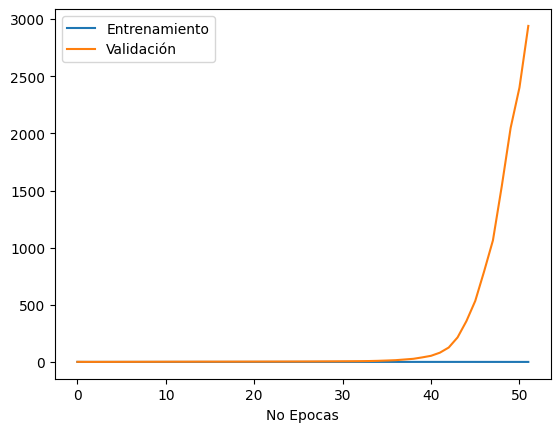

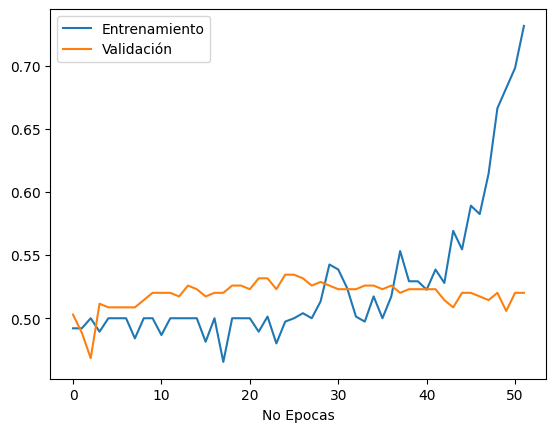

In [156]:
Graficas(hist)

In [218]:
Evaluar_Predecir(model, x_test, y_test, 64)

InvalidArgumentError: Graph execution error:

Detected at node sequential_23/Oculta_No_1/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 608, in run_forever

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1936, in _run_once

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 84, in _run

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 531, in process_one

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 359, in execute_request

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 775, in execute_request

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 446, in do_execute

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\Sebas\AppData\Local\Temp\ipykernel_17160\2314660923.py", line 1, in <module>

  File "C:\Users\Sebas\AppData\Local\Temp\ipykernel_17160\3837015936.py", line 7, in Evaluar_Predecir

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2296, in evaluate

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 4108, in run_step

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2066, in test_function

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2049, in step_function

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2037, in run_step

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1917, in test_step

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py", line 255, in call

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\activations.py", line 306, in relu

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py", line 5395, in relu

Matrix size-incompatible: In[0]: [32,10000], In[1]: [30000,256]
	 [[{{node sequential_23/Oculta_No_1/Relu}}]] [Op:__inference_test_function_89992]

MODELO 2

In [31]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout

model_conv = Sequential()

# Extracción de características
model_conv.add(Input(shape = (100, 100, 3), name = "Entrada"))

# Bloque Convolucional No 1
model_conv.add(Conv2D(filters=10, kernel_size=5, strides=(2, 2), padding='valid', activation='relu', name="Conv_No_1"))
model_conv.add(MaxPooling2D(pool_size=(4, 4), name='MaxPool_No_1'))

# Clasificación
model_conv.add(Flatten(name="Flatten"))
model_conv.add(Dense(512, activation="relu", name="Clasificacion"))
model_conv.add(Dense(2, activation="sigmoid", name="Salida"))
model_conv.summary()

NameError: name 'Sequential' is not defined

In [221]:
model_conv.compile(optimizer='SGD', loss='CategoricalCrossentropy', metrics='CategoricalAccuracy')

In [222]:
callBack_ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

checkpoint_filepath = 'C:/tmp/checkpoints/checkpoint_temp'

callBack_Pesos = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor = 'val_categorical_accuracy', mode = 'max', save_best_only=True)

# hist_conv = model_conv.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

hist_conv = model_conv.fit(x_train, y_train, batch_size = 64, epochs=100, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

Epoch 1/100
12/12 [==============================] - 2s 75ms/step - loss: 0.6998 - categorical_accuracy: 0.5000 - val_loss: 0.6933 - val_categorical_accuracy: 0.5144
Epoch 2/100
12/12 [==============================] - 0s 38ms/step - loss: 0.6936 - categorical_accuracy: 0.4920 - val_loss: 0.6979 - val_categorical_accuracy: 0.4914
Epoch 3/100
12/12 [==============================] - 0s 35ms/step - loss: 0.6931 - categorical_accuracy: 0.5279 - val_loss: 0.6933 - val_categorical_accuracy: 0.4971
Epoch 4/100
12/12 [==============================] - 0s 32ms/step - loss: 0.6916 - categorical_accuracy: 0.5199 - val_loss: 0.6964 - val_categorical_accuracy: 0.5086
Epoch 5/100
12/12 [==============================] - 0s 33ms/step - loss: 0.6876 - categorical_accuracy: 0.5519 - val_loss: 0.6999 - val_categorical_accuracy: 0.4943
Epoch 6/100
12/12 [==============================] - 0s 37ms/step - loss: 0.6887 - categorical_accuracy: 0.5465 - val_loss: 0.6934 - val_categorical_accuracy: 0.5086
Epoc

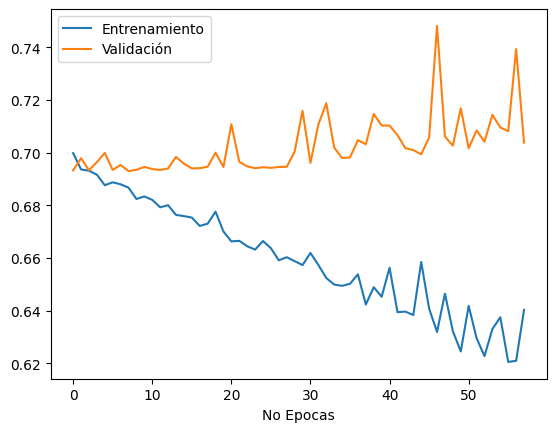

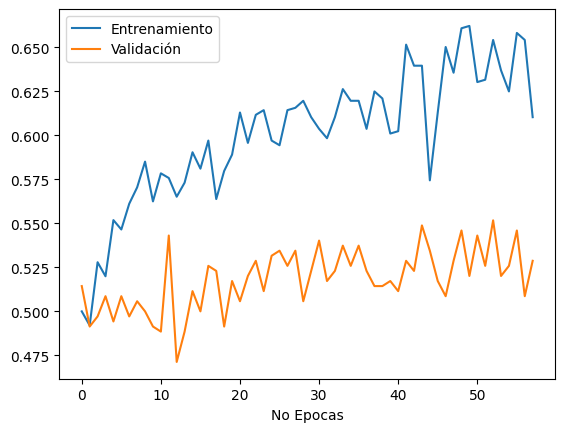

In [223]:
Graficas(hist_conv)

In [1]:
Evaluar_Predecir(model_conv, x_test, y_test, 64)

NameError: name 'Evaluar_Predecir' is not defined

In [177]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout

model_conv = Sequential()

# Extracción de características
model_conv.add(Input(shape = (100, 100, 1), name = "Entrada"))

# Bloque Convolucional No 1
model_conv.add(Conv2D(filters = 20, kernel_size = 4, strides = (3,3), padding = 'valid', name = "Conv_No_1"))
model_conv.add(MaxPooling2D(pool_size = (4,4), name = 'MaxPool_No_1'))

# Clasificación
model_conv.add(Flatten(input_shape = (3,3,10), name = "Entrada_clasif"))
model_conv.add(Dense(512, activation="relu", name = "Clasificacion"))
model_conv.add(Dense(2, activation="sigmoid", name = "Salida"))
model_conv.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_No_1 (Conv2D)          (None, 33, 33, 20)        340       
                                                                 
 MaxPool_No_1 (MaxPooling2D  (None, 8, 8, 20)          0         
 )                                                               
                                                                 
 Entrada_clasif (Flatten)    (None, 1280)              0         
                                                                 
 Clasificacion (Dense)       (None, 512)               655872    
                                                                 
 Salida (Dense)              (None, 2)                 1026      
                                                                 
Total params: 657238 (2.51 MB)
Trainable params: 657238 (2.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [178]:
model_conv.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics='CategoricalAccuracy')

In [179]:
callBack_ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

checkpoint_filepath = 'C:/tmp/checkpoints/checkpoint_temp'

callBack_Pesos = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor = 'val_categorical_accuracy', mode = 'max', save_best_only=True)

# hist_conv = model_conv.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

hist_conv = model_conv.fit(x_train, y_train, batch_size = 64, epochs=100, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

Epoch 1/100
12/12 [==============================] - 2s 54ms/step - loss: 0.6940 - categorical_accuracy: 0.4947 - val_loss: 3.2092 - val_categorical_accuracy: 0.5000
Epoch 2/100
12/12 [==============================] - 0s 19ms/step - loss: 0.6934 - categorical_accuracy: 0.4867 - val_loss: 4.0741 - val_categorical_accuracy: 0.5000
Epoch 3/100
12/12 [==============================] - 0s 19ms/step - loss: 0.6938 - categorical_accuracy: 0.5000 - val_loss: 2.8979 - val_categorical_accuracy: 0.4971
Epoch 4/100
12/12 [==============================] - 0s 31ms/step - loss: 0.6933 - categorical_accuracy: 0.5000 - val_loss: 3.1274 - val_categorical_accuracy: 0.5057
Epoch 5/100
12/12 [==============================] - 0s 18ms/step - loss: 0.6932 - categorical_accuracy: 0.5000 - val_loss: 3.4239 - val_categorical_accuracy: 0.5057
Epoch 6/100
12/12 [==============================] - 0s 18ms/step - loss: 0.6932 - categorical_accuracy: 0.5000 - val_loss: 3.6464 - val_categorical_accuracy: 0.5000
Epoc

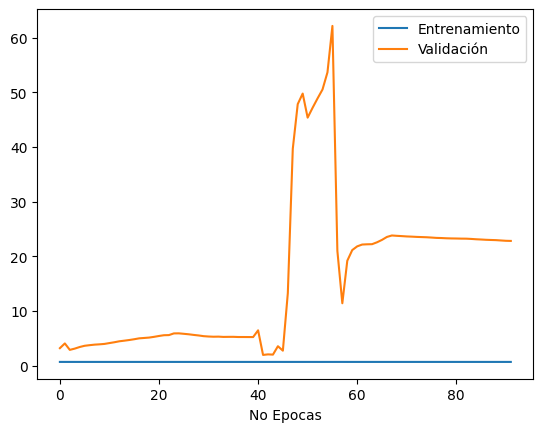

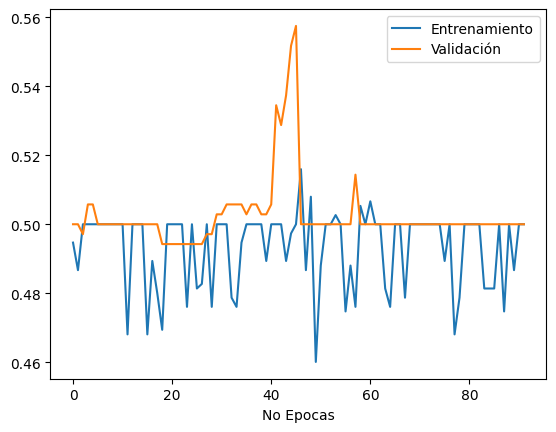

In [180]:
Graficas(hist_conv)

1/1 [==============================] - 0s 45ms/step - loss: 34.6994 - categorical_accuracy: 0.4688
Evaluación: Perdidas [34.699398040771484] Métricas [0.46875]
1/1 [==============================] - 0s 107ms/step


IndexError: index 32 is out of bounds for axis 0 with size 32

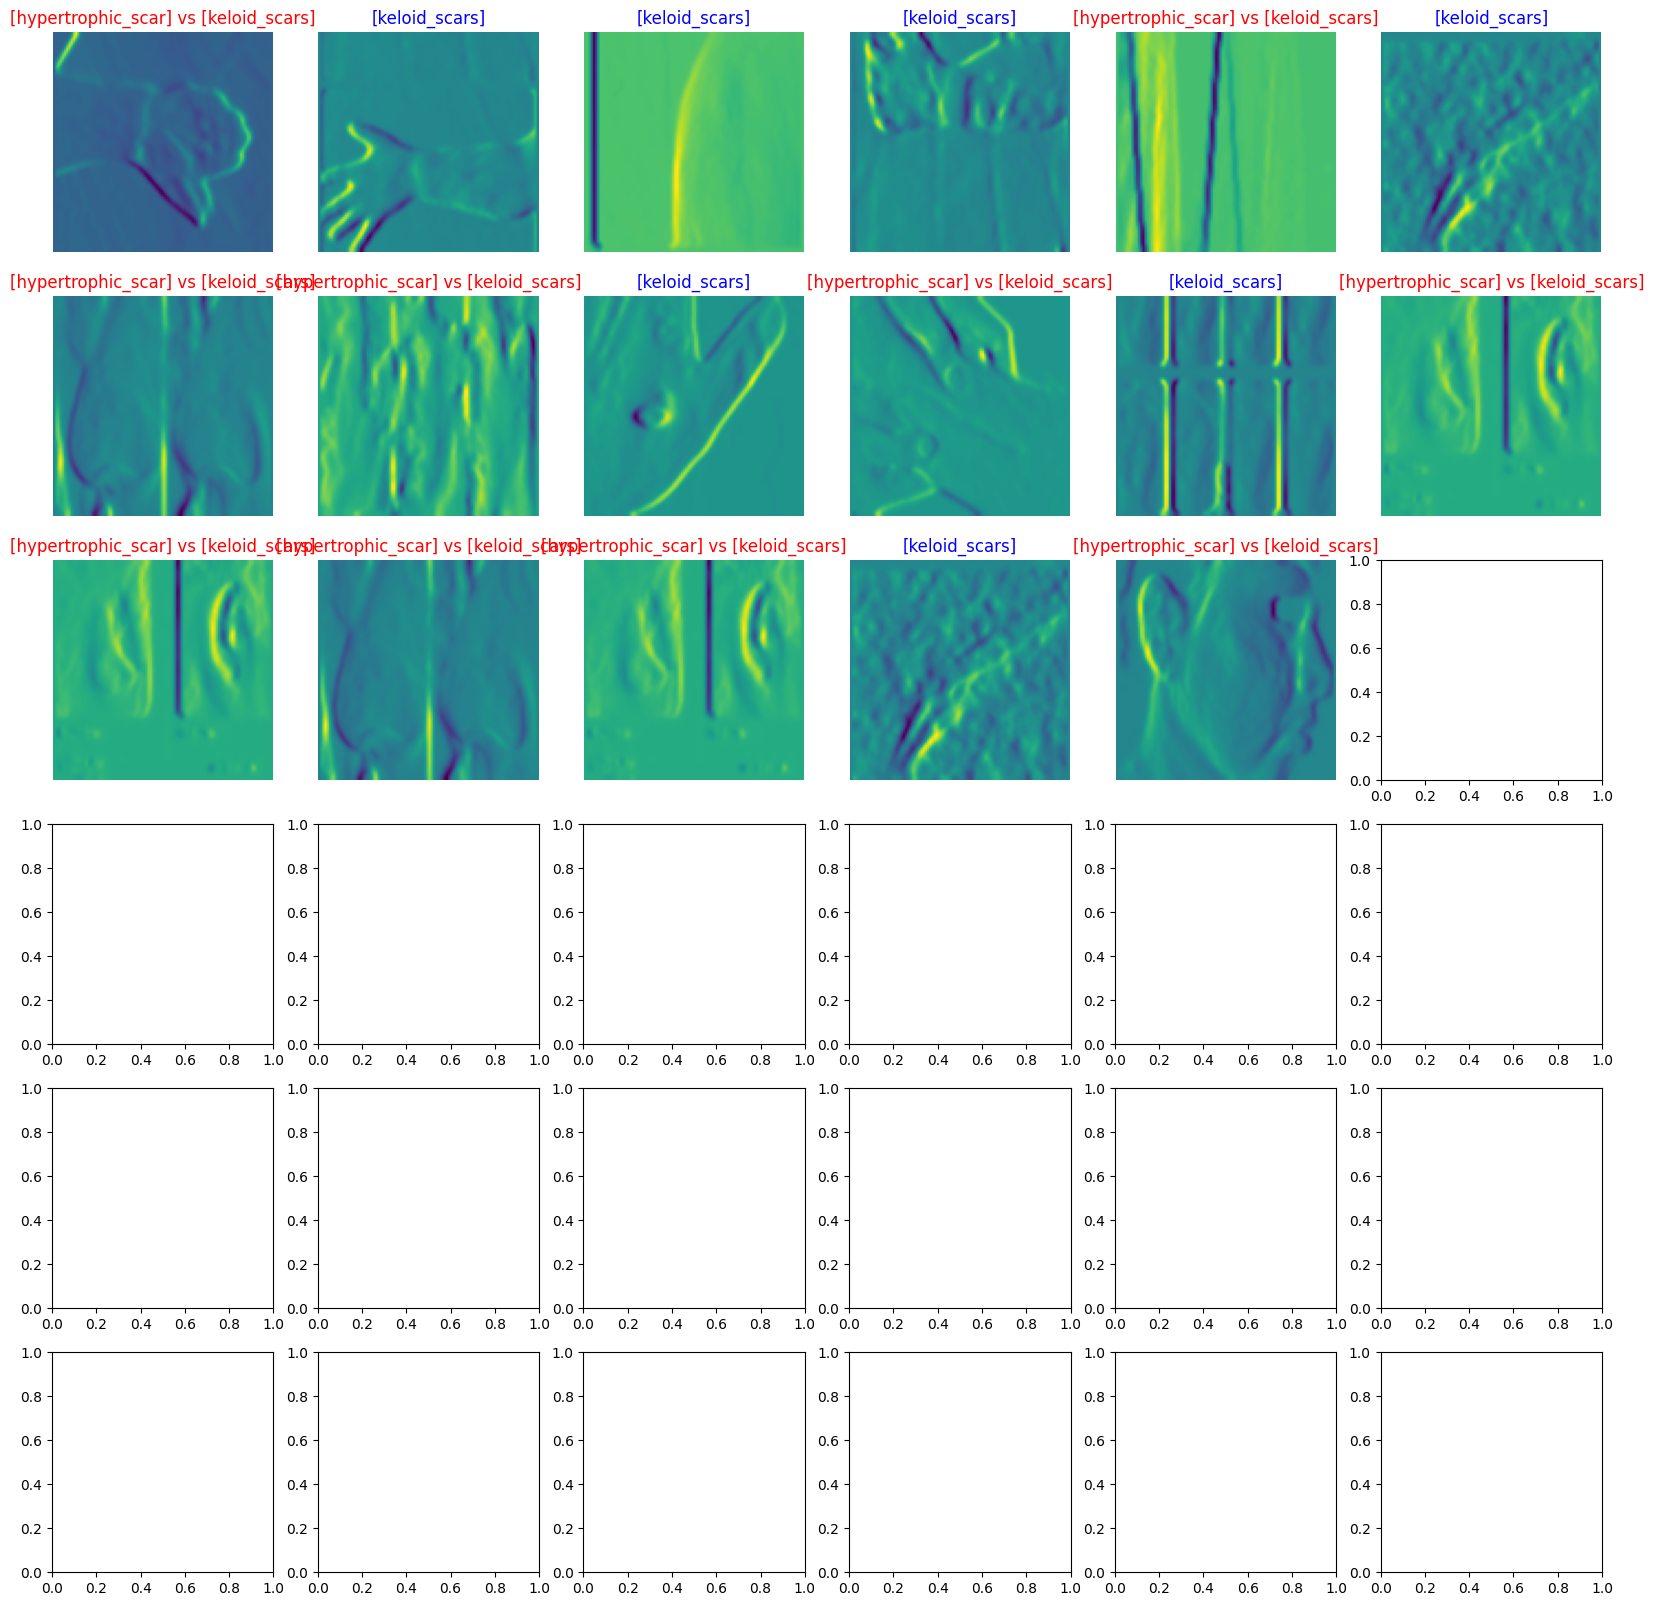

In [181]:
Evaluar_Predecir(model_conv, x_test, y_test, 64)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Crear el modelo
model_conv = Sequential()

# Extracción de características
model_conv.add(Input(shape=(100, 100, 3), name="Entrada"))

# Bloque Convolucional No 1
model_conv.add(Conv2D(filters=20, kernel_size=4, strides=(3, 3), padding='valid', name="Conv_No_1"))
model_conv.add(MaxPooling2D(pool_size=(4, 4), name='MaxPool_No_1'))

# Bloque 2
model_conv.add(Conv2D(filters=10, kernel_size=2, strides=(2, 2), padding='valid', name="Conv_No_2"))
model_conv.add(MaxPooling2D(pool_size=(3, 3), name='MaxPool_No_2'))

# Clasificación
model_conv.add(Flatten(name="Flatten"))
model_conv.add(Dense(512, activation="relu", name="Clasificacion"))
model_conv.add(Dense(256, activation="relu", name="Clasificacion2"))
model_conv.add(Dense(128, activation="relu", name="Clasificacion3"))
model_conv.add(Dense(2, activation="sigmoid", name="Salida"))

# Mostrar resumen del modelo
model_conv.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_No_1 (Conv2D)          (None, 33, 33, 20)        980       
                                                                 
 MaxPool_No_1 (MaxPooling2D  (None, 8, 8, 20)          0         
 )                                                               
                                                                 
 Conv_No_2 (Conv2D)          (None, 4, 4, 10)          810       
                                                                 
 MaxPool_No_2 (MaxPooling2D  (None, 1, 1, 10)          0         
 )                                                               
                                                                 
 Flatten (Flatten)           (None, 10)                0         
                                                                 
 Clasificacion (Dense)       (None, 512)              

In [25]:
model_conv.compile(optimizer='RMSprop', loss='CategoricalCrossentropy', metrics='CategoricalAccuracy')

In [26]:
callBack_ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

checkpoint_filepath = 'C:/tmp/checkpoints/checkpoint_temp'

callBack_Pesos = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor = 'val_categorical_accuracy', mode = 'max', save_best_only=True)

# hist_conv = model_conv.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

hist_conv = model_conv.fit(x_train, y_train, batch_size = 64, epochs=100, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

Epoch 1/100


12/12 [==============================] - 2s 74ms/step - loss: 0.6987 - categorical_accuracy: 0.4840 - val_loss: 0.6973 - val_categorical_accuracy: 0.5000
Epoch 2/100
12/12 [==============================] - 0s 31ms/step - loss: 0.6915 - categorical_accuracy: 0.5399 - val_loss: 0.6898 - val_categorical_accuracy: 0.5920
Epoch 3/100
12/12 [==============================] - 0s 30ms/step - loss: 0.6902 - categorical_accuracy: 0.5266 - val_loss: 0.6900 - val_categorical_accuracy: 0.5948
Epoch 4/100
12/12 [==============================] - 0s 23ms/step - loss: 0.6890 - categorical_accuracy: 0.5253 - val_loss: 0.6890 - val_categorical_accuracy: 0.5316
Epoch 5/100
12/12 [==============================] - 0s 23ms/step - loss: 0.6834 - categorical_accuracy: 0.5718 - val_loss: 0.6919 - val_categorical_accuracy: 0.5316
Epoch 6/100
12/12 [==============================] - 0s 22ms/step - loss: 0.6839 - categorical_accuracy: 0.5412 - val_loss: 0.6926 - val_categorical_accuracy: 0.5086
Ep

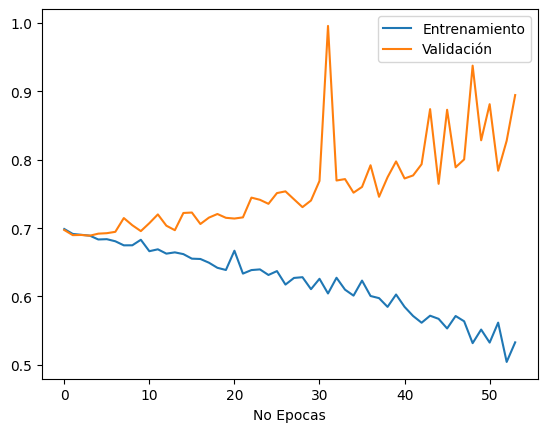

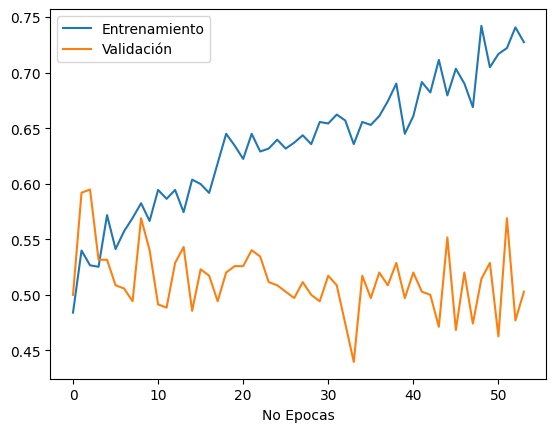

In [27]:
Graficas(hist_conv)

In [28]:
Evaluar_Predecir(model_conv, x_test, y_test, 64)

: 

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir el modelo
def build_model(input_shape, num_classes):
    model = models.Sequential([
        # Capa de convolución con activación ReLU
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        # Capa de MaxPooling para reducir la dimensionalidad
        layers.MaxPooling2D((2, 2)),
        # Capa de convolución con activación ReLU
        layers.Conv2D(64, (3, 3), activation='relu'),
        # Capa de MaxPooling para reducir la dimensionalidad
        layers.MaxPooling2D((2, 2)),
        # Capa de convolución con activación ReLU
        layers.Conv2D(64, (3, 3), activation='relu'),
        # Capa de MaxPooling para reducir la dimensionalidad
        layers.MaxPooling2D((2, 2)),
        # Aplanar los datos para alimentar la red neuronal densa
        layers.Flatten(),
        # Capa densa con activación ReLU
        layers.Dense(64, activation='relu'),
        # Capa de salida con activación softmax para la clasificación
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Crear una instancia del modelo
input_shape = (100, 100, 3)  # Dimensiones de las imágenes de entrada (por ejemplo, imágenes de 100x100 píxeles en RGB)
num_classes = 2  # Número de clases (por ejemplo, 10 clases para el conjunto de datos MNIST)
model = build_model(input_shape, num_classes)

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 10, 10, 64)       

In [29]:
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_val, y_val))


Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 608, in run_forever

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1936, in _run_once

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 84, in _run

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 531, in process_one

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 359, in execute_request

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 775, in execute_request

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 446, in do_execute

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "C:\Users\Sebas\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\Sebas\AppData\Local\Temp\ipykernel_6668\1443702946.py", line 1, in <module>

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 270, in call

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 2454, in sparse_categorical_crossentropy

  File "c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [64,2] and labels shape [128]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_1690]